# Machine Learning in Spark
#### Objective: Build a classification algorithm using Spark ML
#### As part of this activity,
#### 1. Read data, understand data using exploratory data analysis.
#### 2. Do necessary pre-processing and build machine learning classification algorithm using the libraries available in SparkML. 

## Setup

#### Configure Spark Environment
Configure environment variables, Make sure you provide the correct Spark installation path/location.

In [1]:
## Set Python - Spark environment. Resolve necessary dependencies specific to Spark HBase Connector.
import os
import sys

os.environ["SPARK_HOME"] = "/usr/hdp/current/spark2-client"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.6-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

### Starting the Spark Session
#### Create and Initialize Spark Driver
Creating a spark app that will run locally and will use as many threads as there are cores using local[*] :

In [2]:
## Create SparkContext, SparkSession
from os.path import expanduser, join, abspath

from pyspark.sql import SparkSession
from pyspark.sql import Row

# warehouse_location points to the default location for managed databases and tables
warehouse_location = 'hdfs:///apps/hive/warehouse/'

spark = SparkSession \
    .builder \
    .appName("Machine Learning Example using Spark ML") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .enableHiveSupport() \
    .getOrCreate()

#### Verify Spark Driver -  Spark Session

In [3]:
## Verify Spark Session
spark

## Read data and analyse using SparkML

### Bank Marketing Example
we are going to use an example throughout this activity for bank marketing.
Signet bank is the company that started with capital one.

It was a small unknown bank that learned based on its prior data can actually better market to right customers to give them credit cards
they did this back in 1980s before data science is really a thing and since then they've grown to one of largest credit card brands in the world largely based on using data.

**“data on the specific transactions of a bank’s customers can improve models for deciding what product offers to make.”** - Data Science for Business, Provost, Foster - O’Reilly 2013

#### But …
**given a set of examples how do I get training data to the function (i.e. model)?**
![ML4](./Images/ml4.png)

### Data Representation
- **Pandas** - DataFrames represented on a single machine as Python data structures
- **RDDs** - Spark’s foundational structure Resilient Distributed Dataset is represented as a reference to partitioned data without types
- **DataFrames** - Spark’s strongly typed optimized distributed collection of rows

**All ML Algorithms need to represent data as vectors (array of Double values) in order to train machine learning algorithms**

## ML Pipelines
ML Pipelines provide a uniform set of high-level APIs built on top of DataFrames that help users create and tune practical machine learning pipelines and this concept is mostly inspired by the scikit-learn project.

![MLP1](./Images/mlp1.png)
<br>
![MLP2](./Images/mlp2.png)

### SPARK Architecture
![Spark Architecture](./Images/sa.png)

### Single vs Distributed Machine Learning

#### Single Machine Learning
- In a single machine algorithm such as scikit-learn, the data isloaded into the memory of a single machine (usually as Pandas or
NumPy vectors)
- The single machine algorithm iterates (loops) over the data in memory and using a single thread (sometimes multicore) takes a
"guess" at the equation
- The error is calculated and if the error from the previous iteration is less than the tolerance or the iterations are >= max iterations then STOP<br>

#### Distributed Machine Learning
- In Distributed Machine Learning like Spark MLlib, the data is represented as an RDD or a DataFrame typically in distributed file storage such as S3, Blob Store or HDFS
- As a best practice, you should cache the data in memory across the nodes so that multiple iterations don’t have to query the disk each time
- The calculation of the gradients is distributed across all the nodes using Spark's distributed compute engine (similar to MapReduce)
- After each iteration, the results return to the driver and iterations continue until eithermax_iter or tol is reached


### Algorithms
![Logistic Regression](./Images/alg1.png)
![Logistic Regression Implementations](./Images/alg2.png)
![Random Forest](./Images/alg3.png)
![Distributed Random Forest](./Images/alg4.png)

## Spark ML Demonstration

#### Load Dependent Libraries

#### Spark libraries

In [6]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [7]:
import numpy as np
import StringIO
import pandas as pd
import warnings

In [6]:
# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

import plotly
plotly.tools.set_credentials_file(username='<your_user_id>', api_key='<your_API_Key>')

import plotly.figure_factory as ff
import plotly.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

# Initializing some settings
sns.set_style('whitegrid')
sns.set(color_codes=True)
warnings.filterwarnings('ignore')
pyoff.init_notebook_mode(connected=True)
get_ipython().magic('matplotlib inline')

#### Problem Statement
The dataset is from a bank, data related to direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, to access if the product (bank term deposit) would be (or not) subscribed. The data and attribute description are in the folder.

#### Dataset Description
The dataset has the following attributes:
<br>1 - unique sequence id
<br>2 - age (numeric)
<br>3 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student", "blue-collar","self-employed","retired","technician","services")
<br>4 - marital_status : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
<br>5 - education (categorical: "unknown","secondary","primary","tertiary")
<br>6 - default: has credit in default? (binary: "yes","no")
<br>7 - balance: average yearly balance, in euros (numeric)
<br>8 - housing: has housing loan? (binary: "yes","no")
<br>9 - loan: has personal loan? (binary: "yes","no")
<br>10 - contact: contact communication type (categorical: "unknown","telephone","cellular")
<br>11 - day: last contact day of the month (numeric)
<br>12 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
<br>13 - duration: last contact duration, in seconds (numeric)
<br>14 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
<br>15 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
<br>16 - previous: number of contacts performed before this campaign and for this client (numeric)
<br>17 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")
<br>**18 - opened_new_td_act_no_yes - has the client subscribed to a term deposit? (binary: "yes","no")**

<html>
<font color="blue">
<br>
The idea is we have set of information about a person whether its their age the job they have the marital status whether they have loan with the bank or not etc. we're trying to decide here is whether this person open a new deposit account with this bank.
</br><br><br>
So the theory here is that if I can better target the right customers with the right offer at right time they'll convert over to actually open a deposit account with the bank so that I don't have to reach out whole population and waste a lot of money with ads or mailer or what ever have you but target only the perspective customers.
</br></font>
</html>

#### Define the schema for the dataset and use this to create the DataFrame

In [4]:
!pwd

/nfsroot/data/home/jayantm/Batches/Batch48/SparkML


In [8]:
## Define Schema
bankDataSchema = StructType([
         StructField("age", IntegerType(), True),
         StructField("job", StringType(), True),
         StructField("marital_status", StringType(), True),
         StructField("education", StringType(), True),
         StructField("default", StringType(), True),
         StructField("balance", DoubleType(), True),
         StructField("housing", StringType(), True),
         StructField("loan", StringType(), True),        
         StructField("contact", StringType(), True),
         StructField("day", IntegerType(), True),
         StructField("month", StringType(), True),
         StructField("duration", DoubleType(), True),
         StructField("campaign", DoubleType(), True),
         StructField("pdays", DoubleType(), True),
         StructField("previous", DoubleType(), True),
         StructField("poutcome", StringType(), True),
         StructField("opened_new_td_act_no_yes", StringType(), True)])

#### Using the above schema read data and create DataFrame

In [9]:
# Reading and create from local files
bankDF = spark.read.format("csv")\
        .option("header", "false")\
        .option("inferSchema", "true")\
        .load("file:///home/jayantm/Batches/Batch48/SparkML/bank_data.csv", schema = bankDataSchema)

# Reading and create from HDFS
# bankDF = spark.read.format("csv")\
#         .option("header", "false")\
#         .option("inferSchema", "true")\
#         .load("/user/rameshm/<path>/bank_data.csv", schema = bankDataSchema)
        
# bankDF = spark.read.format("csv")\
#         .option("header", "false")\
#         .option("inferSchema", "true")\
#         .load("hdfs:///user/rameshm/<path>/bank_data.csv", schema = bankDataSchema)

#### Verify Schema

In [9]:
bankDF.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: double (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: double (nullable = true)
 |-- campaign: double (nullable = true)
 |-- pdays: double (nullable = true)
 |-- previous: double (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- opened_new_td_act_no_yes: string (nullable = true)



#### Check datatype of each column/field/attribute/feature

In [10]:
bankDF.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital_status', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'double'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('duration', 'double'),
 ('campaign', 'double'),
 ('pdays', 'double'),
 ('previous', 'double'),
 ('poutcome', 'string'),
 ('opened_new_td_act_no_yes', 'string')]

#### Cache DataFrame
Calling cache on the DataFrame will make sure we persist it in memory the first time it is used.
<br>The following uses will be able to read from memory, instead of re-reading the data from disk.

In [11]:
bankDF.cache()

DataFrame[age: int, job: string, marital_status: string, education: string, default: string, balance: double, housing: string, loan: string, contact: string, day: int, month: string, duration: double, campaign: double, pdays: double, previous: double, poutcome: string, opened_new_td_act_no_yes: string]

#### Verify first few records

In [12]:
## To Show first n observations
## Use head operation to see first n observations (say, 10 observations). 
## Head operation in PySpark is similar to head operation in Pandas.
bankDF.take(2)

[Row(age=30, job=u'unemployed', marital_status=u'married', education=u'primary', default=u'no', balance=1787.0, housing=u'no', loan=u'no', contact=u'cellular', day=19, month=u'oct', duration=79.0, campaign=1.0, pdays=-1.0, previous=0.0, poutcome=u'unknown', opened_new_td_act_no_yes=u'no'),
 Row(age=33, job=u'services', marital_status=u'married', education=u'secondary', default=u'no', balance=4789.0, housing=u'yes', loan=u'yes', contact=u'cellular', day=11, month=u'may', duration=220.0, campaign=1.0, pdays=339.0, previous=4.0, poutcome=u'failure', opened_new_td_act_no_yes=u'no')]

In [13]:
## Above results are comprised of row like format. 
## To see the result in more interactive manner (rows under the columns), Use the show operation. 
## Show operation on train and take first 5 rows of it. 
bankDF.show(2)

+---+----------+--------------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+------------------------+
|age|       job|marital_status|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|opened_new_td_act_no_yes|
+---+----------+--------------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+------------------------+
| 30|unemployed|       married|  primary|     no| 1787.0|     no|  no|cellular| 19|  oct|    79.0|     1.0| -1.0|     0.0| unknown|                      no|
| 33|  services|       married|secondary|     no| 4789.0|    yes| yes|cellular| 11|  may|   220.0|     1.0|339.0|     4.0| failure|                      no|
+---+----------+--------------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+------------------------+
only showing top 2 rows



#### Verify the total rows and columns

In [14]:
## To Count the number of rows in DataFrame
print('Total records count is {}'.format(bankDF.count()))
## Columns count and column names
print("Total Columns count is {}".format(len(bankDF.columns)))
print("\n\nColumns are: {} \n".format(bankDF.columns))

Total records count is 4521
Total Columns count is 17


Columns are: ['age', 'job', 'marital_status', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'opened_new_td_act_no_yes'] 



#### Verify the Summary Statistics

In [15]:
## To get the summary statistics (mean, standard deviance, min ,max , count) of columns in a DataFrame
bankDF.describe().show()

+-------+------------------+-------+--------------+---------+-------+------------------+-------+----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+------------------------+
|summary|               age|    job|marital_status|education|default|           balance|housing|loan| contact|               day|month|          duration|          campaign|             pdays|          previous|poutcome|opened_new_td_act_no_yes|
+-------+------------------+-------+--------------+---------+-------+------------------+-------+----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+------------------------+
|  count|              4521|   4521|          4521|     4521|   4521|              4521|   4521|4521|    4521|              4521| 4521|              4521|              4521|              4521|              4521|    4521|                    4521|
|   mean| 41.170

In [16]:
## Verify summary stats for few fields
bankDF.describe().select('summary', 'age', 'loan', 'balance', 'pdays').show()

+-------+------------------+----+------------------+------------------+
|summary|               age|loan|           balance|             pdays|
+-------+------------------+----+------------------+------------------+
|  count|              4521|4521|              4521|              4521|
|   mean| 41.17009511170095|null|1422.6578190665782|39.766644547666445|
| stddev|10.576210958711263|null|3009.6381424673395|100.12112444301656|
|    min|                19|  no|           -3313.0|              -1.0|
|    max|                87| yes|           71188.0|             871.0|
+-------+------------------+----+------------------+------------------+



#### Distinct values count in each column

In [17]:
## Find the Distinct values count in each column
bankDF.agg(*(countDistinct(col(c)).alias(c) for c in bankDF.columns)).show()

+---+---+--------------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------------------------+
|age|job|marital_status|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|opened_new_td_act_no_yes|
+---+---+--------------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------------------------+
| 67| 12|             3|        4|      2|   2353|      2|   2|      3| 31|   12|     875|      32|  292|      24|       4|                       2|
+---+---+--------------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------------------------+



#### Maximum values in each column

In [18]:
## Find maximum value in each column
bankDF.agg(*(max(col(c)).alias(c) for c in bankDF.columns)).show()

+---+-------+--------------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------------------------+
|age|    job|marital_status|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|opened_new_td_act_no_yes|
+---+-------+--------------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------------------------+
| 87|unknown|        single|  unknown|    yes|71188.0|    yes| yes|unknown| 31|  sep|  3025.0|    50.0|871.0|    25.0| unknown|                     yes|
+---+-------+--------------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------------------------+



#### Minimum values in each column

In [19]:
## Find maximum value in each column
bankDF.agg(*(min(col(c)).alias(c) for c in bankDF.columns)).show()

+---+------+--------------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+------------------------+
|age|   job|marital_status|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|opened_new_td_act_no_yes|
+---+------+--------------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+------------------------+
| 19|admin.|      divorced|  primary|     no|-3313.0|     no|  no|cellular|  1|  apr|     4.0|     1.0| -1.0|     0.0| failure|                      no|
+---+------+--------------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+------------------------+



#### Observation:
The minimum value in the balance column is negative
<br>Verify how many such negative values exists in the balance column

In [20]:
print("Total count of negative values in balance column are: {}".format(bankDF.where(bankDF.balance < 0).count()))

Total count of negative values in balance column are: 366


### Data Pre-Processing

#### Replace the negative balances with the ZEROES

In [21]:
## Replace negative balances with zeroes
from pyspark.sql.functions import when
bankDF = bankDF.withColumn('balance', when(bankDF.balance > 0, bankDF.balance).otherwise(0))
zeroBalance = bankDF.where(bankDF.balance < 0)
zeroBalance.count()

0

#### Define a table/view to run sql queries on the dataframe

In [22]:
## Create view/table
bankDF.createOrReplaceTempView("bankDFTable")

#### Verify the target distribution

In [23]:
## Multiple ways of referring a column in a dataframe
resultDF = spark.sql("""
SELECT opened_new_td_act_no_yes, COUNT(*) AS Count
FROM bankDFTable
GROUP BY opened_new_td_act_no_yes
""")

resultDF.show()

+------------------------+-----+
|opened_new_td_act_no_yes|Count|
+------------------------+-----+
|                      no| 4000|
|                     yes|  521|
+------------------------+-----+



In [24]:
pdDF = resultDF.toPandas()
data = [
    go.Bar(
        x=pdDF['opened_new_td_act_no_yes'], # assign x as the dataframe column 'x'
        y=pdDF['Count']
    )
]
layout = go.Layout(title='Term Deposit Opted Yes/No Counts',)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='plot_1')

#### Pair wise frequency between Target (opened_new_td_act_no_yes) and loan columns

In [25]:
pdresultDF = bankDF.crosstab("opened_new_td_act_no_yes", "loan")

In [26]:
resultDF.show()

+-----------------------------+----+---+
|opened_new_td_act_no_yes_loan|  no|yes|
+-----------------------------+----+---+
|                          yes| 478| 43|
|                           no|3352|648|
+-----------------------------+----+---+



In [27]:
pdDF = resultDF.toPandas()
pdDF.columns = ['opened_new_td_act_no_yes', 'No_Existing_Loans', 'Existing_Loan']
trace1 = go.Bar(
    x=['Opted for TD', 'Not Opted for TD'],
    y=pdDF['No_Existing_Loans'],
    name='No Existing Loans'
)

trace2 = go.Bar(
    x=['Opted for TD', 'Not Opted for TD'],
    y=pdDF['Existing_Loan'],
    name='Existing Loans'
)

data = [trace1, trace2]
layout = go.Layout(
    title='Term Deposit Accounts vs Existing Loan Counts',
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='plot_2')

#### Term Deposit Opted Counts for different job categories

In [28]:
resultDF = spark.sql("""
SELECT 
    job,
    COUNT(*) AS term_deposit_yes_cnt
    FROM bankDFTable 
    WHERE opened_new_td_act_no_yes = "yes"
    GROUP BY job
""")

In [29]:
pdDF = resultDF.toPandas()
data = [
    go.Bar(
        x=pdDF['job'], # assign x as the dataframe column 'x'
        y=pdDF['term_deposit_yes_cnt']
    )
]
layout = go.Layout(title='Term Deposit Opted Counts in each Job Category',)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='plot_3')

#### Term Deposit Not-Opted Counts for different job categories

In [30]:
resultDF = spark.sql("""
SELECT 
    job,
    COUNT(*) AS term_deposit_no_cnt
    FROM bankDFTable 
    WHERE opened_new_td_act_no_yes = "no"
    GROUP BY job
""")

In [31]:
pdDF = resultDF.toPandas()
data = [
    go.Bar(
        x=pdDF['job'], # assign x as the dataframe column 'x'
        y=pdDF['term_deposit_no_cnt']
    )
]
layout = go.Layout(title='Term Deposit Count in each Job Category',)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='plot_4')

#### Term Deposits Counts for different education levels

In [32]:
resultDF = bankDF.filter(expr("opened_new_td_act_no_yes = 'yes'")).groupBy("education").count()

In [33]:
resultDF.show()

+---------+-----+
|education|count|
+---------+-----+
|  unknown|   19|
| tertiary|  193|
|secondary|  245|
|  primary|   64|
+---------+-----+



In [34]:
pdDF = resultDF.toPandas()
data = [
    go.Bar(
        x=pdDF['education'], # assign x as the dataframe column 'x'
        y=pdDF['count']
    )
]
layout = go.Layout(title='Term Deposit Opted Count in each Education Level',)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='plot_5')

In [35]:
resultDF = bankDF.filter(expr("opened_new_td_act_no_yes = 'no'")).groupBy("education").count()

In [36]:
pdDF = resultDF.toPandas()
data = [
    go.Bar(
        x=pdDF['education'], # assign x as the dataframe column 'x'
        y=pdDF['count']
    )
]
layout = go.Layout(title='Term Deposit Not-Opted Count in each Education Level',)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='plot_6')

#### Pair wise frequency between Target (opened_new_td_act_no_yes) and marital_status columns

In [37]:
resultDF = bankDF.crosstab('opened_new_td_act_no_yes', 'marital_status')

In [38]:
resultDF.show()

+---------------------------------------+--------+-------+------+
|opened_new_td_act_no_yes_marital_status|divorced|married|single|
+---------------------------------------+--------+-------+------+
|                                    yes|      77|    277|   167|
|                                     no|     451|   2520|  1029|
+---------------------------------------+--------+-------+------+



In [39]:
resultDF = spark.sql("""
SELECT opened_new_td_act_no_yes,
    SUM(CASE WHEN marital_status = 'divorced' THEN 1 ELSE 0 END) divorced_Count,
    SUM(CASE WHEN marital_status = 'married' THEN 1 ELSE 0 END) married_Count,
    SUM(CASE WHEN marital_status = 'single' THEN 1 ELSE 0 END) single_Count
from bankDFTable
GROUP BY opened_new_td_act_no_yes
""")

In [40]:
resultDF.show()

+------------------------+--------------+-------------+------------+
|opened_new_td_act_no_yes|divorced_Count|married_Count|single_Count|
+------------------------+--------------+-------------+------------+
|                      no|           451|         2520|        1029|
|                     yes|            77|          277|         167|
+------------------------+--------------+-------------+------------+



In [41]:
pdDF = resultDF.toPandas()
trace1 = go.Bar(
    x=pdDF['opened_new_td_act_no_yes'],
    y=pdDF['divorced_Count'],
    name='Divorced Count'
)

trace2 = go.Bar(
    x=pdDF['opened_new_td_act_no_yes'],
    y=pdDF['married_Count'],
    name='Married Count'
)

trace3 = go.Bar(
    x=pdDF['opened_new_td_act_no_yes'],
    y=pdDF['single_Count'],
    name='Single Count'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    title='term depoisit opted/not-opted vs marital_status Counts',
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='plot_7')

#### Pair wise frequency between Target (opened_new_td_act_no_yes) and default columns

In [42]:
resultDF = bankDF.crosstab('default', 'opened_new_td_act_no_yes')
resultDF.show()

+--------------------------------+----+---+
|default_opened_new_td_act_no_yes|  no|yes|
+--------------------------------+----+---+
|                             yes|  67|  9|
|                              no|3933|512|
+--------------------------------+----+---+



In [43]:
pdDF = resultDF.toPandas()
trace1 = go.Bar(
    x=['Defaulted_Yes', 'Defaulted_No'],
    y=pdDF['no'],
    name='Not Opted'
)

trace2 = go.Bar(
    x=['Defaulted_Yes', 'Defaulted_No'],
    y=pdDF['yes'],
    name='Opted'
)

data = [trace1, trace2]
layout = go.Layout(
    title='Default vs term deposit Counts',
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='plot_8')

#### Convert Spark DataFrame into Pandas DataFrame

In [44]:
bankDF_pd = bankDF.toPandas()
bankDF_pd.head()

,age,job,marital_status,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,opened_new_td_act_no_yes
0,30,unemployed,married,primary,no,1787.0,no,no,cellular,19,oct,79.0,1.0,-1.0,0.0,unknown,no
1,33,services,married,secondary,no,4789.0,yes,yes,cellular,11,may,220.0,1.0,339.0,4.0,failure,no
2,35,management,single,tertiary,no,1350.0,yes,no,cellular,16,apr,185.0,1.0,330.0,1.0,failure,no
3,30,management,married,tertiary,no,1476.0,yes,yes,unknown,3,jun,199.0,4.0,-1.0,0.0,unknown,no
4,59,blue-collar,married,secondary,no,0.0,yes,no,unknown,5,may,226.0,1.0,-1.0,0.0,unknown,no


#### Derive Correlations for the numeric columns

In [45]:
correlations = bankDF_pd.corr()
correlations

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.084202,-0.017853,-0.002367,-0.005148,-0.008894,-0.003511
balance,0.084202,1.000000,-0.007595,-0.015195,-0.010840,0.008616,0.026031
day,-0.017853,-0.007595,1.000000,-0.024629,0.160706,-0.094352,-0.059114
duration,-0.002367,-0.015195,-0.024629,1.000000,-0.068382,0.010380,0.018080
campaign,-0.005148,-0.010840,0.160706,-0.068382,1.000000,-0.093137,-0.067833
pdays,-0.008894,0.008616,-0.094352,0.010380,-0.093137,1.000000,0.577562
previous,-0.003511,0.026031,-0.059114,0.018080,-0.067833,0.577562,1.000000


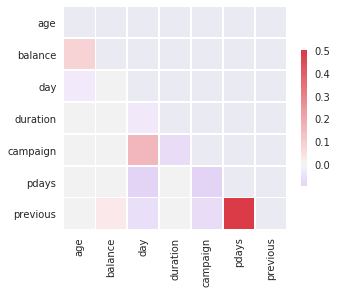

In [46]:
#sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))
    
# Generate a custom diverging colormap
cmap = sns.diverging_palette(1000, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [47]:
trace = go.Heatmap(z=[correlations['age'], correlations['balance'],correlations['day'],correlations['duration'],
                      correlations['campaign'],correlations['pdays'],correlations['previous']],
                   x=['age','balance','day','duration','campaign','pdays','previous'],
                   y=['age','balance','day','duration','campaign','pdays','previous'])
data=[trace]
layout = go.Layout(title='Heat Map',)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='plot_9')

#### Verify for Null Values

In [48]:
bankDF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in bankDF.columns]).show()

+---+---+--------------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------------------------+
|age|job|marital_status|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|opened_new_td_act_no_yes|
+---+---+--------------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------------------------+
|  0|  0|             0|        0|      0|      0|      0|   0|      0|  0|    0|       0|       0|    0|       0|       0|                       0|
+---+---+--------------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+------------------------+



#### Remove Null values - if any

In [49]:
data_df = bankDF.na.drop( how = 'any' )
print('Before Dropping Null Values', bankDF.count())
print('After Dropping Null Values', data_df.count())

('Before Dropping Null Values', 4521)
('After Dropping Null Values', 4521)


#### Split the data into training and test sets (30% held out for testing)

In [50]:
(trainingData, testData) = bankDF.randomSplit([0.7, 0.3])

In [51]:
trainingData.show(4)

+---+-------+--------------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+------------------------+
|age|    job|marital_status|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|opened_new_td_act_no_yes|
+---+-------+--------------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+------------------------+
| 19|student|        single|  primary|     no|  103.0|     no|  no|cellular| 10|  jul|   104.0|     2.0| -1.0|     0.0| unknown|                     yes|
| 19|student|        single|  unknown|     no|    0.0|     no|  no|cellular| 11|  feb|   123.0|     3.0| -1.0|     0.0| unknown|                      no|
| 19|student|        single|  unknown|     no| 1169.0|     no|  no|cellular|  6|  feb|   463.0|    18.0| -1.0|     0.0| unknown|                      no|
| 20|student|        single|secondary|     no|  502.0|     no|  no|cellular|

In [52]:
testData.show(4)

+---+-------+--------------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+------------------------+
|age|    job|marital_status|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|poutcome|opened_new_td_act_no_yes|
+---+-------+--------------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+------------------------+
| 19|student|        single|secondary|     no|  302.0|     no|  no| cellular| 16|  jul|   205.0|     1.0| -1.0|     0.0| unknown|                     yes|
| 20|student|        single|secondary|     no|  291.0|     no|  no|telephone| 11|  may|   172.0|     5.0|371.0|     5.0| failure|                      no|
| 21|student|        single|secondary|     no| 6844.0|     no|  no| cellular| 14|  aug|   126.0|     3.0|127.0|     7.0|   other|                      no|
| 22|student|        single|  unknown|     no|  549.0|     no|  no| ce

#### Define PipeLines
<br>Stages:
    -  Preprocessing
    -  Model Building & Evaluation

#### Extract Categorical and Numerical Columns from the data

In [53]:
cat_Var_Names = ['job', 'marital_status', 'education', 'default', 'housing', 
                 'day', 'contact', 'month', 'poutcome']

num_Var_Names = ['age', 'balance', 'duration', 'previous', 'pdays', 'campaign']

#### Use VectorAssembler to combine a given list of numcolumns into a single vector column.

In [54]:
from pyspark.ml.feature import VectorAssembler

vector_assembler_NumVars = VectorAssembler(inputCols=num_Var_Names, outputCol="num_features_all")

#### Scale all the numeric attributes using MinMaxScaler
MinMaxScaler transforms a dataset of Vector rows, rescaling each feature to a specific range (often [0, 1]). 
<br>MinMaxScaler computes summary statistics on a data set and produces a MinMaxScalerModel. 
<br>The model can then transform each feature individually such that it is in the given range.

In [55]:
from pyspark.ml.feature import MinMaxScaler
min_Max_Scalar_NumVars = MinMaxScaler(inputCol="num_features_all", outputCol = "scaled_num_features")

#### convert Categorical Variables into Numeric
Dummify (encode) the categorical variables.

In [56]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

indexers_Cat  = [StringIndexer(inputCol=cat_Var_Name, outputCol="{0}_index".format(cat_Var_Name)) 
                 for cat_Var_Name in cat_Var_Names ]

encoders_Cat  = [OneHotEncoder(inputCol=indexer.getOutputCol(), 
                               outputCol="{0}_vec".format(indexer.getInputCol())) 
                 for indexer in indexers_Cat]

assembler_Cat = VectorAssembler(inputCols=[encoder.getOutputCol() 
                                           for encoder in encoders_Cat], outputCol="cat_features")

assembler     = VectorAssembler(inputCols=["scaled_num_features","cat_features"], outputCol="features")

#### Encode Target Attribute

In [57]:
indexer_Label = StringIndexer(inputCol="opened_new_td_act_no_yes", outputCol="label")

#### Preprocessing Steps

In [58]:
# Combine numerical attributes into a vector
# Scale above vector
# String Indexing on Categorical attributes
# OneHot Encoder on the above indexers
# Combine all the encoded Categorical vectors into a single  vector
# Combine both Numerical and Categorical into a one vector
# Target attribute
preprocessiong_Stages = [vector_assembler_NumVars] +\
                        [min_Max_Scalar_NumVars] +\
                        indexers_Cat + encoders_Cat +\
                        [assembler_Cat] +\
                        [assembler] +\
                        [indexer_Label]

### Model Building and Evaluation

![Logistic Regression](./Images/lrc.png)

In [59]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=10, labelCol="label", featuresCol="features")

In [60]:
from pyspark.ml import Pipeline

lr_Pipeline = Pipeline(stages=preprocessiong_Stages+[lr])

lr_Pipeline_model = lr_Pipeline.fit(trainingData)

In [61]:
print("Coefficients: " + str(lr_Pipeline_model.stages[-1].coefficients))
print("Intercept: " + str(lr_Pipeline_model.stages[-1].intercept))

Coefficients: [0.38267508690855057,-0.5033931923588367,14.06974752884051,1.8998480546316128,0.776632314897214,-4.385225651671993,0.1268634342162756,-0.32510252989104993,-0.1665770100213951,0.31291173705449626,0.06344165643873399,0.7265594559298927,-0.1062643533450591,-0.3865637248966043,-1.1521675720390687,-0.7993068653402221,0.6310289048019435,-0.07614665621622817,-0.09765487733950919,-0.08385393225835223,0.1964133780316038,-0.0332485308812,-0.05224594763147373,-0.3996694800336062,-0.7370082042702106,0.0784500284893516,0.3144061434514063,-0.8594381063036938,-0.8912699559884062,-0.7152518931010623,-0.6509960499317207,0.49062140746414445,-0.09225422176422318,-0.11178777552707887,-0.8082224009649385,0.6954997061638718,0.5421725572759974,-0.059542508941468286,-0.1286688340934399,0.10479831988103708,0.21369267767701358,0.42063432549867763,0.015356120184716611,-0.13563827735464234,0.3018024137789141,-0.048279156185675944,0.035294999873141865,-0.36598004193212014,-0.4616572039219479,0.448823

In [62]:
train_predictions_lr = lr_Pipeline_model.transform(trainingData)
test_predictions_lr = lr_Pipeline_model.transform(testData)

In [63]:
test_predictions_lr.show(2)

+---+-------+--------------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+------------------------+--------------------+--------------------+---------+--------------------+---------------+-------------+-------------+---------+-------------+-----------+--------------+---------------+------------------+-------------+-------------+-----------+---------------+-------------+--------------+-------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|age|    job|marital_status|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|poutcome|opened_new_td_act_no_yes|    num_features_all| scaled_num_features|job_index|marital_status_index|education_index|default_index|housing_index|day_index|contact_index|month_index|poutcome_index|        job_vec|marital_status_vec|education_vec|  default_vec|housing_vec|        day_vec|  contact_vec|     month_vec|

In [64]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
predictionAndLabels_train_lr = train_predictions_lr.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
train_accuracy_lr = evaluator.evaluate(predictionAndLabels_train_lr)
print("Train set accuracy  = " + str(train_accuracy_lr))
print("Train Error = %g" % (1.0 - train_accuracy_lr))

predictionAndLabels_test_lr = test_predictions_lr.select("prediction", "label")
test_accuracy_lr = evaluator.evaluate(predictionAndLabels_test_lr)
print("Test set accuracy = " + str(test_accuracy_lr))
print("Test Error = %g" % (1.0 - test_accuracy_lr))

Train set accuracy  = 0.903056498919
Train Error = 0.0969435
Test set accuracy = 0.904836193448
Test Error = 0.0951638


### METRICS
Below we calculate some more metrics. The number of false and true positive and negative predictions is also useful:
- **true positives (TP):** These are cases in which we predicted yes (they had term deposit), and they do had the 
- **true negatives (TN):** We predicted no, and they don't have the term deposit.
- **false positives (FP):** We predicted yes, but they don't actually have the term deposit. (Also known as a "Type I error.")
- **false negatives (FN):** We predicted no, but they actually do have the term deposit. (Also known as a "Type II error.")

This is a list of metrics that are often computed from a confusion matrix for a binary classifier:
    
- **Accuracy:** Overall, how often is the classifier correct? (TP+TN)/total
- **Misclassification Rate:** Overall, how often is it wrong? (FP+FN)/total
    - equivalent to 1 minus Accuracy, also known as "**Error Rate**"
- **True Positive Rate:** When it's actually yes, how often does it predict yes? TP/actual yes
    - also known as "**Sensitivity**" or "**Recall**"
- **False Positive Rate:** When it's actually no, how often does it predict yes? FP/actual no
- **True Negative Rate:** When it's actually no, how often does it predict no? TN/actual no
    - equivalent to 1 minus False Positive Rate, also known as "**Specificity**"
- **Precision:** When it predicts yes, how often is it correct? TP/predicted yes
- **F1 Score:** This is a weighted average of the true positive rate (recall) and precision. 

In [65]:
true_positive = predictionAndLabels_train_lr[(predictionAndLabels_train_lr.label == 1) & (predictionAndLabels_train_lr.prediction == 1.0)].count()
true_negative = predictionAndLabels_train_lr[(predictionAndLabels_train_lr.label == 0) & (predictionAndLabels_train_lr.prediction == 0.0)].count()
false_positive = predictionAndLabels_train_lr[(predictionAndLabels_train_lr.label == 0) & (predictionAndLabels_train_lr.prediction == 1.0)].count()
false_negative = predictionAndLabels_train_lr[(predictionAndLabels_train_lr.label == 1) & (predictionAndLabels_train_lr.prediction == 0.0)].count()

print "TRAIN METRICS - LINEAR MODEL - BINOMIAL FAMILY"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_lr.count()

precission = true_positive / float(true_positive + false_positive)
print "Precission: ", precission
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall)))
print("*****************************************************************************")
true_positive = predictionAndLabels_test_lr[(predictionAndLabels_test_lr.label == 1) & (predictionAndLabels_test_lr.prediction == 1.0)].count()
true_negative = predictionAndLabels_test_lr[(predictionAndLabels_test_lr.label == 0) & (predictionAndLabels_test_lr.prediction == 0.0)].count()
false_positive = predictionAndLabels_test_lr[(predictionAndLabels_test_lr.label == 0) & (predictionAndLabels_test_lr.prediction == 1.0)].count()
false_negative = predictionAndLabels_test_lr[(predictionAndLabels_test_lr.label == 1) & (predictionAndLabels_test_lr.prediction == 0.0)].count()
print "TEST METRICS - LINEAR MODEL - BINOMIAL FAMILY"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_lr.count()
precission = true_positive / float(true_positive + false_positive)
print "Precission: ", precission
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall)))


TRAIN METRICS - LINEAR MODEL - BINOMIAL FAMILY
True Positives: 158
True Negatives: 2767
False Positives: 82
False Negatives: 232
Total 3239
Precission:  0.658333333333
Recall:  0.405128205128
F1 Score:  0.501587301587
*****************************************************************************
TEST METRICS - LINEAR MODEL - BINOMIAL FAMILY
True Positives: 38
True Negatives: 1122
False Positives: 29
False Negatives: 93
Total 3239
Precission:  0.567164179104
Recall:  0.290076335878
F1 Score:  0.383838383838


In [66]:
train_pred_pandas = predictionAndLabels_train_lr.toPandas()
train_actuals = train_pred_pandas.label.tolist()
train_predictions = train_pred_pandas.prediction.tolist()


test_pred_pandas = predictionAndLabels_test_lr.toPandas()
test_actuals = test_pred_pandas.label.tolist()
test_predictions = test_pred_pandas.prediction.tolist()
from sklearn import metrics as smetrics
cm = smetrics.confusion_matrix(train_actuals, train_predictions)

              Not Approved  Approved
Not Approved          2767        82
Approved               232       158


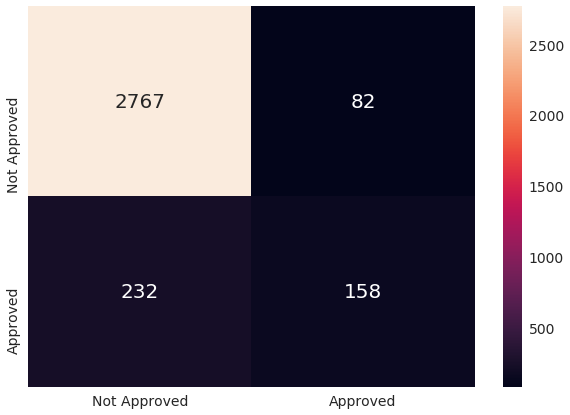

In [67]:
df_cm = pd.DataFrame(cm)
df_cm.index = ['Not Approved', 'Approved']
df_cm.columns = ['Not Approved', 'Approved']
names=['Not Approved', 'Approved']
print(df_cm)
fig = plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,fmt="d",annot_kws={"size": 20})# 

![Decision Tree Classifier](./Images/dtc.png)

In [68]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

In [69]:
dt_Pipeline = Pipeline(stages=preprocessiong_Stages+[dt]) 

dt_Pipeline_model = dt_Pipeline.fit(trainingData)

In [70]:
train_predictions_dt = dt_Pipeline_model.transform(trainingData)
test_predictions_dt = dt_Pipeline_model.transform(testData)

In [71]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictionAndLabels_train_dt = train_predictions_dt.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
train_accuracy = evaluator.evaluate(predictionAndLabels_train_dt)
print("Train set accuracy  = " + str(train_accuracy))
print("Train Error = %g" % (1.0 - train_accuracy))

predictionAndLabels_test_dt = test_predictions_dt.select("prediction", "label")
test_accuracy = evaluator.evaluate(predictionAndLabels_test_dt)
print("Test set accuracy = " + str(test_accuracy))
print("Test Error = %g" % (1.0 - test_accuracy))

Train set accuracy  = 0.911083667799
Train Error = 0.0889163
Test set accuracy = 0.897035881435
Test Error = 0.102964


In [72]:
true_positive = predictionAndLabels_train_dt[(predictionAndLabels_train_dt.label == 1) & (predictionAndLabels_train_dt.prediction == 1.0)].count()
true_negative = predictionAndLabels_train_dt[(predictionAndLabels_train_dt.label == 0) & (predictionAndLabels_train_dt.prediction == 0.0)].count()
false_positive = predictionAndLabels_train_dt[(predictionAndLabels_train_dt.label == 0) & (predictionAndLabels_train_dt.prediction == 1.0)].count()
false_negative = predictionAndLabels_train_dt[(predictionAndLabels_train_dt.label == 1) & (predictionAndLabels_train_dt.prediction == 0.0)].count()
print "TRAIN METRICS - DECISSION TREE CLASSIFIER"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_dt.count()
precission = true_positive / float(true_positive + false_positive)
print "Precission: ", precission
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall)))
print("*****************************************************************************")
true_positive = predictionAndLabels_test_dt[(predictionAndLabels_test_dt.label == 1) & (predictionAndLabels_test_dt.prediction == 1.0)].count()
true_negative = predictionAndLabels_test_dt[(predictionAndLabels_test_dt.label == 0) & (predictionAndLabels_test_dt.prediction == 0.0)].count()
false_positive = predictionAndLabels_test_dt[(predictionAndLabels_test_dt.label == 0) & (predictionAndLabels_test_dt.prediction == 1.0)].count()
false_negative = predictionAndLabels_test_dt[(predictionAndLabels_test_dt.label == 1) & (predictionAndLabels_test_dt.prediction == 0.0)].count()
print "\n\nTEST METRICS - DECISSION TREE CLASSIFIER"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_dt.count()
precission = true_positive / float(true_positive + false_positive)
print "Precission: ", precission
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall)))

TRAIN METRICS - DECISSION TREE CLASSIFIER
True Positives: 175
True Negatives: 2776
False Positives: 73
False Negatives: 215
Total 3239
Precission:  0.70564516129
Recall:  0.448717948718
F1 Score:  0.548589341693
*****************************************************************************


TEST METRICS - DECISSION TREE CLASSIFIER
True Positives: 36
True Negatives: 1114
False Positives: 37
False Negatives: 95
Total 3239
Precission:  0.493150684932
Recall:  0.274809160305
F1 Score:  0.352941176471


In [73]:
treeModel = dt_Pipeline_model.stages[23]

In [74]:
print "Learned classification tree model:"
print treeModel.toDebugString

Learned classification tree model:
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4c36a3e153d96605fd27) of depth 5 with 59 nodes
  If (feature 2 <= 0.2015888778550149)
   If (feature 2 <= 0.07232704402515724)
    If (feature 0 <= 0.6102941176470589)
     If (feature 3 <= 0.020833333333333332)
      If (feature 61 in {1.0})
       Predict: 0.0
      Else (feature 61 not in {1.0})
       Predict: 0.0
     Else (feature 3 > 0.020833333333333332)
      If (feature 58 in {1.0})
       Predict: 0.0
      Else (feature 58 not in {1.0})
       Predict: 0.0
    Else (feature 0 > 0.6102941176470589)
     If (feature 2 <= 0.06835484938761999)
      If (feature 17 in {0.0})
       Predict: 1.0
      Else (feature 17 not in {0.0})
       Predict: 0.0
     Else (feature 2 > 0.06835484938761999)
      If (feature 1 <= 0.07452098668314885)
       Predict: 1.0
      Else (feature 1 > 0.07452098668314885)
       Predict: 0.0
   Else (feature 2 > 0.07232704402515724)
    If (feature 4 <= 0.0

![Random Forest Classifier](./Images/rfc.png)

In [75]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

In [76]:
rf_Pipeline = Pipeline(stages=preprocessiong_Stages+[rf]) 
rf_Pipeline_model = rf_Pipeline.fit(trainingData)

In [77]:
train_predictions_rf = rf_Pipeline_model.transform(trainingData)
test_predictions_rf = rf_Pipeline_model.transform(testData)

In [78]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
predictionAndLabels_train_rf = train_predictions_rf.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
train_accuracy = evaluator.evaluate(predictionAndLabels_train_rf)
print("Train set accuracy  = " + str(train_accuracy))
print("Train Error = %g" % (1.0 - train_accuracy))

predictionAndLabels_test_rf = test_predictions_rf.select("prediction", "label")
test_accuracy = evaluator.evaluate(predictionAndLabels_test_rf)
print("Test set accuracy = " + str(test_accuracy))
print("Test Error = %g" % (1.0 - test_accuracy))

Train set accuracy  = 0.882679839457
Train Error = 0.11732
Test set accuracy = 0.895475819033
Test Error = 0.104524


In [79]:
true_positive = predictionAndLabels_train_rf[(predictionAndLabels_train_rf.label == 1) & (predictionAndLabels_train_rf.prediction == 1.0)].count()
true_negative = predictionAndLabels_train_rf[(predictionAndLabels_train_rf.label == 0) & (predictionAndLabels_train_rf.prediction == 0.0)].count()
false_positive = predictionAndLabels_train_rf[(predictionAndLabels_train_rf.label == 0) & (predictionAndLabels_train_rf.prediction == 1.0)].count()
false_negative = predictionAndLabels_train_rf[(predictionAndLabels_train_rf.label == 1) & (predictionAndLabels_train_rf.prediction == 0.0)].count()
print "TRAIN METRICS - RANDOM FOREST CLASSIFIER"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_rf.count()
precission = true_positive / float(true_positive + false_positive)
print "Precission: ", precission
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall)))
print("*****************************************************************************")

true_positive = predictionAndLabels_test_rf[(predictionAndLabels_test_rf.label == 1) & (predictionAndLabels_test_rf.prediction == 1.0)].count()
true_negative = predictionAndLabels_test_rf[(predictionAndLabels_test_rf.label == 0) & (predictionAndLabels_test_rf.prediction == 0.0)].count()
false_positive = predictionAndLabels_test_rf[(predictionAndLabels_test_rf.label == 0) & (predictionAndLabels_test_rf.prediction == 1.0)].count()
false_negative = predictionAndLabels_test_rf[(predictionAndLabels_test_rf.label == 1) & (predictionAndLabels_test_rf.prediction == 0.0)].count()
print "TEST METRICS - RANDOM FOREST CLASSIFIER"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_rf.count()
#precission = true_positive / float(true_positive + false_positive)
print "Precission: ", precission
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall)))

TRAIN METRICS - RANDOM FOREST CLASSIFIER
True Positives: 10
True Negatives: 2849
False Positives: 0
False Negatives: 380
Total 3239
Precission:  1.0
Recall:  0.025641025641
F1 Score:  0.05
*****************************************************************************
TEST METRICS - RANDOM FOREST CLASSIFIER
True Positives: 0
True Negatives: 1148
False Positives: 3
False Negatives: 131
Total 3239
Precission:  1.0
Recall:  0.0
F1 Score:  0.0


![Gradient Boosted Tree Classifier](./Images/gbtc.png)

In [80]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

In [81]:
gbt_Pipeline = Pipeline(stages=preprocessiong_Stages+[gbt]) 
gbt_Pipeline_model = gbt_Pipeline.fit(trainingData)

In [82]:
train_predictions_gbt = gbt_Pipeline_model.transform(trainingData)
test_predictions_gbt = gbt_Pipeline_model.transform(testData)

In [83]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
predictionAndLabels_train_gbt = train_predictions_gbt.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
train_accuracy = evaluator.evaluate(predictionAndLabels_train_gbt)
print("Train set accuracy  = " + str(train_accuracy))
print("Train Error = %g" % (1.0 - train_accuracy))

predictionAndLabels_test_gbt = test_predictions_gbt.select("prediction", "label")
test_accuracy = evaluator.evaluate(predictionAndLabels_test_gbt)
print("Test set accuracy = " + str(test_accuracy))
print("Test Error = %g" % (1.0 - test_accuracy))

Train set accuracy  = 0.926829268293
Train Error = 0.0731707
Test set accuracy = 0.894695787832
Test Error = 0.105304


In [84]:
true_positive = predictionAndLabels_train_gbt[(predictionAndLabels_train_gbt.label == 1) & (predictionAndLabels_train_gbt.prediction == 1.0)].count()
true_negative = predictionAndLabels_train_gbt[(predictionAndLabels_train_gbt.label == 0) & (predictionAndLabels_train_gbt.prediction == 0.0)].count()
false_positive = predictionAndLabels_train_gbt[(predictionAndLabels_train_gbt.label == 0) & (predictionAndLabels_train_gbt.prediction == 1.0)].count()
false_negative = predictionAndLabels_train_gbt[(predictionAndLabels_train_gbt.label == 1) & (predictionAndLabels_train_gbt.prediction == 0.0)].count()
print "TRAIN METRICS - GRADIENT-BOOSTED TREE CLASSIFIER"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_gbt.count()
precission = true_positive / float(true_positive + false_positive)
print "Precission: ", precission
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall)))
print("*****************************************************************************")
true_positive = predictionAndLabels_test_gbt[(predictionAndLabels_test_gbt.label == 1) & (predictionAndLabels_test_gbt.prediction == 1.0)].count()
true_negative = predictionAndLabels_test_gbt[(predictionAndLabels_test_gbt.label == 0) & (predictionAndLabels_test_gbt.prediction == 0.0)].count()
false_positive = predictionAndLabels_test_gbt[(predictionAndLabels_test_gbt.label == 0) & (predictionAndLabels_test_gbt.prediction == 1.0)].count()
false_negative = predictionAndLabels_test_gbt[(predictionAndLabels_test_gbt.label == 1) & (predictionAndLabels_test_gbt.prediction == 0.0)].count()
print "TEST METRICS - GRADIENT-BOOSTED TREE CLASSIFIER"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_gbt.count()
precission = true_positive / float(true_positive + false_positive)
print "Precission: ", precission
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall)))

TRAIN METRICS - GRADIENT-BOOSTED TREE CLASSIFIER
True Positives: 201
True Negatives: 2801
False Positives: 48
False Negatives: 189
Total 3239
Precission:  0.807228915663
Recall:  0.515384615385
F1 Score:  0.629107981221
*****************************************************************************
TEST METRICS - GRADIENT-BOOSTED TREE CLASSIFIER
True Positives: 38
True Negatives: 1109
False Positives: 42
False Negatives: 93
Total 3239
Precission:  0.475
Recall:  0.290076335878
F1 Score:  0.36018957346


![Multilayer Perceptron](./Images/mlp3_1.png)
![Multilayer Perceptron](./Images/mlp4.png)

In [85]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# specify layers for the neural network:
# input layer of size 71 (features), two intermediate of size 5 and 4
# and output of size 2 (classes)
layers = [70, 50, 40, 2]
# create the trainer and set its parameters
mlp = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)

In [86]:
mlp_Pipeline = Pipeline(stages=preprocessiong_Stages+[mlp]) 
mlp_Pipeline_model = mlp_Pipeline.fit(trainingData)

In [87]:
train_predictions_mlp = mlp_Pipeline_model.transform(trainingData)
test_predictions_mlp = mlp_Pipeline_model.transform(testData)

In [88]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
predictionAndLabels_train_mlp = train_predictions_mlp.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
train_accuracy = evaluator.evaluate(predictionAndLabels_train_mlp)
print("Train set accuracy  = " + str(train_accuracy))
print("Train Error = %g" % (1.0 - train_accuracy))

predictionAndLabels_test_mlp = test_predictions_mlp.select("prediction", "label")
test_accuracy = evaluator.evaluate(predictionAndLabels_test_mlp)
print("Test set accuracy = " + str(test_accuracy))
print("Test Error = %g" % (1.0 - test_accuracy))

Train set accuracy  = 0.950293300401
Train Error = 0.0497067
Test set accuracy = 0.884555382215
Test Error = 0.115445


In [89]:
true_positive = predictionAndLabels_train_mlp[(predictionAndLabels_train_mlp.label == 1) & (predictionAndLabels_train_mlp.prediction == 1.0)].count()
true_negative = predictionAndLabels_train_mlp[(predictionAndLabels_train_mlp.label == 0) & (predictionAndLabels_train_mlp.prediction == 0.0)].count()
false_positive = predictionAndLabels_train_mlp[(predictionAndLabels_train_mlp.label == 0) & (predictionAndLabels_train_mlp.prediction == 1.0)].count()
false_negative = predictionAndLabels_train_mlp[(predictionAndLabels_train_mlp.label == 1) & (predictionAndLabels_train_mlp.prediction == 0.0)].count()
print "TRAIN METRICS - MULTI-LAYER PERCEPTRON CLASSIFIER"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_mlp.count()
precission = true_positive / float(true_positive + false_positive + 1)
print "Precission: ", precission
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall+1)))
print("*****************************************************************************")
true_positive = predictionAndLabels_test_mlp[(predictionAndLabels_test_mlp.label == 1) & (predictionAndLabels_test_mlp.prediction == 1.0)].count()
true_negative = predictionAndLabels_test_mlp[(predictionAndLabels_test_mlp.label == 0) & (predictionAndLabels_test_mlp.prediction == 0.0)].count()
false_positive = predictionAndLabels_test_mlp[(predictionAndLabels_test_mlp.label == 0) & (predictionAndLabels_test_mlp.prediction == 1.0)].count()
false_negative = predictionAndLabels_test_mlp[(predictionAndLabels_test_mlp.label == 1) & (predictionAndLabels_test_mlp.prediction == 0.0)].count()
print "TEST METRICS - MULTI-LAYER PERCEPTRON CLASSIFIER"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_mlp.count()
precission = true_positive / (float(true_positive + false_positive) + 1)
print "Precission: ", precission
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall+1)))

TRAIN METRICS - MULTI-LAYER PERCEPTRON CLASSIFIER
True Positives: 307
True Negatives: 2771
False Positives: 78
False Negatives: 83
Total 3239
Precission:  0.795336787565
Recall:  0.787179487179
F1 Score:  0.48485487638
*****************************************************************************
TEST METRICS - MULTI-LAYER PERCEPTRON CLASSIFIER
True Positives: 55
True Negatives: 1079
False Positives: 72
False Negatives: 76
Total 3239
Precission:  0.4296875
Recall:  0.419847328244
F1 Score:  0.195079482798
